In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import pandas as pd
from pandas import concat
from numpy import asarray
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import datetime
from statsmodels.tsa.tsatools import lagmat
from statsmodels.tsa.arima.model import ARIMA

# Data Import and Cleaning

In [2]:
%store -r df_cleaned

In [3]:
df = df_cleaned 

In [4]:
TS1 = df[(df['Plz'] == "['25', '24']")]
TS1_A2 = TS1[TS1['full'] == 'A2 -  geschreddert']
TS1_A1A2 = TS1[TS1['full'] == 'A1 & A2 -  geschreddert']
TS1_A2A3 = TS1[TS1['full'] == 'A2 & A3 -  geschreddert']

In [5]:
nobs = 6
df_train, df_test = TS1_A1A2[0:-nobs], TS1_A1A2[-nobs:]

## Decision Tree

### Walk-forward

In [6]:
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
 n_vars = 1 if type(data) is list else data.shape[1]
 df = pd.DataFrame(data)
 cols = list()
 # input sequence (t-n, ... t-1)
 for i in range(n_in, 0, -1):
    cols.append(df.shift(i))
 # forecast sequence (t, t+1, ... t+n)
 for i in range(0, n_out):
    cols.append(df.shift(-i))
    # put it all together
    agg = concat(cols, axis=1)
# drop rows with NaN values
 if dropnan:
    agg.dropna(inplace=True)
 return agg.values

In [7]:
X = TS1_A1A2["wPreis"].values.reshape(-1, 1)
dt_data = series_to_supervised(X, n_in=4)

In [8]:
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
 return data[:-n_test, :], data[-n_test:, :]

In [9]:
from sklearn.tree import DecisionTreeRegressor


In [10]:
# walk-forward validation for univariate data
def dt_walk_forward_validation(data, n_test):
 predictions = list()
 direction_accuracies = list() 
 # split dataset
 train, test = train_test_split(data, n_test)
 # seed history with training dataset
 history = [x for x in train]
 # step over each time-step in the test set
 for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # fit model on history and make a prediction
    yhat = decision_tree_forecast(history, testX)
    # store forecast in list of predictions
    predictions.append(yhat)
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # add actual observation to history for the next loop
    history.append(test[i])
    # summarize progress
    # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
 # estimate prediction error
 mae = mean_absolute_error(test[:, -1], predictions)
 me = np.mean(predictions - test[:, -1])  # Mean Error
 rmse = mean_squared_error(test[:, -1], predictions, squared=False)
 overall_direction_accuracy = np.mean(direction_accuracies)

 return {'mae':mae, 'me': me, 'rmse': rmse, 'expected':test[:, -1], 'predictions': predictions, 'direction_accuracy': overall_direction_accuracy}

# return error, me, rmse ,test[:, -1], predictions, overall_direction_accuracy 

In [11]:
# fit an random forest model and make a one step prediction
def decision_tree_forecast(train, testX):
 # transform list into array
 train = asarray(train)
 # split into input and output columns
 trainX, trainy = train[:, :-1], train[:, -1]
 # fit model
 model = DecisionTreeRegressor(random_state=42)
 model.fit(trainX, trainy)
 # make a one-step prediction
 yhat = model.predict([testX])
 #print(yhat)
 return yhat[0]

In [12]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Walk-forward forecast Accuracy of: wPreis')
wf_accuracy_prod = dt_walk_forward_validation(dt_data, 6)
# for k, v in wf_accuracy_prod.items():
#     print(adjust(k), ': ', round(v,4))

Decision Tree Walk-forward forecast Accuracy of: wPreis


MAE: 7.835
ME: 1.156
RMSE: 9.811
Direction Accuracy: 0.600


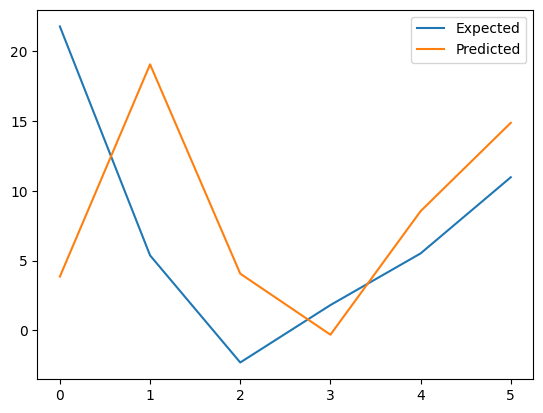

In [13]:
mae = wf_accuracy_prod['mae']
me = wf_accuracy_prod['me']
rmse = wf_accuracy_prod['rmse']
expected = wf_accuracy_prod['expected']
predictions = wf_accuracy_prod['predictions']
direction_accuracy = wf_accuracy_prod['direction_accuracy']

# evaluate
# mae, me, rmse, y, yhat, direction_accuracy = dt_walk_forward_validation(dt_data, 6)
print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % direction_accuracy)
# plot expected vs preducted
plt.plot(expected, label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [14]:
results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [direction_accuracy]
}

# Convert the dictionary into a DataFrame
DecisionTree_wf = pd.DataFrame(results)
DecisionTree_wf

,mae,me,rmse,direction_accuracy
0,7.835223,1.155846,9.811467,0.6


In [15]:
%store DecisionTree_wf


Stored 'DecisionTree_wf' (DataFrame)


### Rolling forecast for Decision Tree

Since this method uses 4 lagged values as input for predicting the next step, we are exposing the test data set in every iteration. So essentially this is a forecast with a window of "input" moving along the test set, predicting one step at a time, but having been trained on the original training set only once.

In [16]:
train, test = train_test_split(dt_data, 6)
train = asarray(train)
trainX, trainy = train[:, :-1], train[:, -1]


In [17]:
model_dt_rolling = DecisionTreeRegressor(random_state=42, max_depth = 3)
model_dt_rolling.fit(trainX, trainy)

DecisionTreeRegressor(max_depth=3, random_state=42)

In [18]:
predictions = list()
direction_accuracies = list() 

In [19]:
for i in range(len(test)):
    # split test row into input and output columns
    testX, testy = test[i, :-1], test[i, -1]
    # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
    print([testX])
    yhat = model_dt_rolling.predict([testX])
    # store forecast in list of predictions
    predictions.append(yhat[0])
    if i > 0:  # Direction accuracy is not applicable for the first prediction
            forecast_diff = yhat - predictions[-2]
            actual_diff = testy - test[i - 1, -1]
            direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
            direction_accuracies.append(direction_accuracy)
    # summarize progress
    print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


[array([19.08385688, 22.15590367, 14.05657364,  5.70419682])]
>expected=21.8, predicted=9.5
[array([22.15590367, 14.05657364,  5.70419682, 21.77178067])]
>expected=5.4, predicted=22.9
[array([14.05657364,  5.70419682, 21.77178067,  5.37221127])]
>expected=-2.3, predicted=9.5
[array([ 5.70419682, 21.77178067,  5.37221127, -2.29737704])]
>expected=1.8, predicted=-0.8
[array([21.77178067,  5.37221127, -2.29737704,  1.8152799 ])]
>expected=5.5, predicted=9.5
[array([ 5.37221127, -2.29737704,  1.8152799 ,  5.51596431])]
>expected=11.0, predicted=9.5


In [20]:
test[0, :-1]

array([19.08385688, 22.15590367, 14.05657364,  5.70419682])

In [21]:
model_dt_rolling.predict([test[0, :-1]])

array([9.46715256])

In [22]:
[test[1, :-1]]

[array([22.15590367, 14.05657364,  5.70419682, 21.77178067])]

In [23]:
model_dt_rolling.predict([test[1, :-1]])

array([22.89070885])

In [24]:
[test[2, :-1]]

[array([14.05657364,  5.70419682, 21.77178067,  5.37221127])]

In [25]:
model_dt_rolling.predict([test[2, :-1]])

array([9.46715256])

In [26]:
for i in range(len(test)):
    print(test[i, :-1])

[19.08385688 22.15590367 14.05657364  5.70419682]
[22.15590367 14.05657364  5.70419682 21.77178067]
[14.05657364  5.70419682 21.77178067  5.37221127]
[ 5.70419682 21.77178067  5.37221127 -2.29737704]
[21.77178067  5.37221127 -2.29737704  1.8152799 ]
[ 5.37221127 -2.29737704  1.8152799   5.51596431]


In [27]:
test

array([[19.08385688, 22.15590367, 14.05657364,  5.70419682, 21.77178067],
       [22.15590367, 14.05657364,  5.70419682, 21.77178067,  5.37221127],
       [14.05657364,  5.70419682, 21.77178067,  5.37221127, -2.29737704],
       [ 5.70419682, 21.77178067,  5.37221127, -2.29737704,  1.8152799 ],
       [21.77178067,  5.37221127, -2.29737704,  1.8152799 ,  5.51596431],
       [ 5.37221127, -2.29737704,  1.8152799 ,  5.51596431, 10.97189655]])

In [28]:
predictions

[9.467152555774701,
 22.890708848225458,
 9.467152555774701,
 -0.8189239997617042,
 9.467152555774701,
 9.467152555774701]

In [29]:
test[:, -1]

array([21.77178067,  5.37221127, -2.29737704,  1.8152799 ,  5.51596431,
       10.97189655])

MAE: 8.280
ME: 2.798
RMSE: 10.178
Direction Accuracy: 0.400


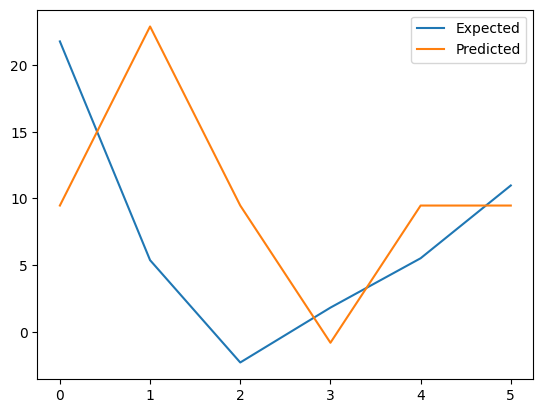

In [30]:
mae = mean_absolute_error(test[:, -1], predictions)
me = np.mean(predictions - test[:, -1])  # Mean Error
rmse = mean_squared_error(test[:, -1], predictions, squared=False)
overall_direction_accuracy = np.mean(direction_accuracies)

print('MAE: %.3f' % mae)
print('ME: %.3f' % me)
print('RMSE: %.3f' % rmse)
print('Direction Accuracy: %.3f' % overall_direction_accuracy)
# plot expected vs preducted
plt.plot(test[:, -1], label='Expected')
plt.plot(predictions, label='Predicted')
plt.legend()
plt.show()

In [31]:
roll_results = {
    'mae': [mae],
    'me': [me],
    'rmse': [rmse],
    'direction_accuracy': [overall_direction_accuracy]
}

# Convert the dictionary into a DataFrame
DecisionTree_roll = pd.DataFrame(roll_results)
DecisionTree_roll

,mae,me,rmse,direction_accuracy
0,8.279632,2.79844,10.177761,0.4


In [32]:
%store DecisionTree_roll

Stored 'DecisionTree_roll' (DataFrame)


## Static (Multi-step) Forecast

Since the above methods use the 4-week lagged values as inputs, it is not possible to use the same method to do static (multi-step) forecasting. For this, we will need to train the model on the original training dataset, not expose it to the test data set and ask it to predict for 6 steps ahead. 

This can be achieved using the ForecasterAutoreg class from the SKforecast package. This class turns any regressor compatible with the scikit-learn API into a recursive autoregressive (multi-step) forecaster.

In [33]:
from skforecast.ForecasterAutoreg import ForecasterAutoreg

In [34]:
# Define the forecaster
forecaster = ForecasterAutoreg(
    # Add the sklearn regressor and lags
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 4
)

In [35]:
y_train = df_train['wPreis']

# Check if y_train is a pandas Series
# print(isinstance(y_train, pd.Series))  # Should print True

In [36]:
# Now you can pass y_train to forecaster.fit()
forecaster.fit(y=y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [37]:
# Predict the test period
predicted_test = forecaster.predict(steps = len(df_test))

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [38]:
predicted_test

4    8.543595
5    3.564921
6    9.247801
7    6.450720
8    3.912658
9    2.668804
Name: pred, dtype: float64

In [39]:
def forecast_accuracy(forecast, actual):
      mae = mean_absolute_error(actual, forecast) # MAE
      me = np.mean(forecast - actual)             # ME
      rmse = np.mean((forecast - actual)**2)**.5  # RMSE
      # Direction accuracy
      forecast_diff = np.diff(forecast)
      actual_diff = np.diff(actual)
      direction_accuracy = np.mean(np.sign(forecast_diff) == np.sign(actual_diff))
    
      return {'mae': mae, 'me': me, 'rmse': rmse, 'direction_accuracy': direction_accuracy}


In [40]:
predicted_test.index = df_test.index


Decision Tree Static Forecast Accuracy of: wPreis
mae    :  6.8537
me     :  -1.4602
rmse   :  8.2112
direction_accuracy :  0.2


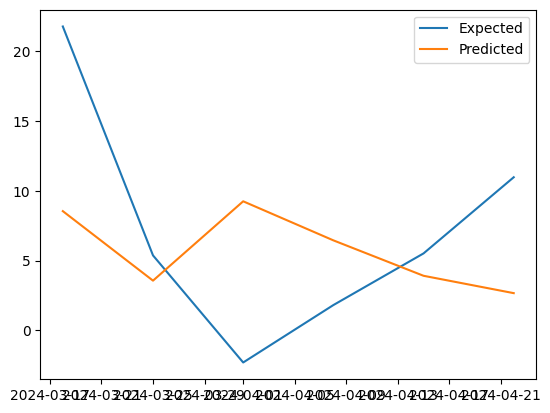

In [41]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Static Forecast Accuracy of: wPreis')
stat_accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
for k, v in stat_accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))


# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predicted_test, label='Predicted')
plt.legend()
plt.show()

In [42]:
DecisionTree_static = pd.DataFrame([stat_accuracy_prod])
DecisionTree_static



,mae,me,rmse,direction_accuracy
0,6.853749,-1.460209,8.211187,0.2


In [43]:
%store DecisionTree_static

Stored 'DecisionTree_static' (DataFrame)


## Walk-forward validation

Now we try the Walk-forward validation using the ForecasterAutoreg to check the results against the standard method

In [44]:
history = y_train 

In [45]:
predictions = list()
for t in range(len(df_test)): # 6 times reiterate
    forecaster.fit(y=history)
    output = forecaster.predict(steps = 1)
    predictions.append(output)
    obs = df_test['wPreis'][t]
    obs_series = pd.Series(obs)
    history = history.append(obs_series, ignore_index=True)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(


In [46]:
predictions 

[4    8.543595
 Name: pred, dtype: float64,
 182    19.057581
 Name: pred, dtype: float64,
 183    4.063304
 Name: pred, dtype: float64,
 184   -0.307413
 Name: pred, dtype: float64,
 185    21.771781
 Name: pred, dtype: float64,
 186    10.848469
 Name: pred, dtype: float64]

In [47]:
predictions_series = pd.concat(predictions, ignore_index=True)
predictions_series.index = df_test.index
predictions_series

date
2024-03-18     8.543595
2024-03-25    19.057581
2024-04-01     4.063304
2024-04-08    -0.307413
2024-04-15    21.771781
2024-04-22    10.848469
Name: pred, dtype: float64

In [48]:
def adjust(val, length= 6): return str(val).ljust(length) # length
print('Decision Tree Walk-forward Forecast Accuracy of: wPreis')
accuracy_prod = forecast_accuracy(predictions_series, df_test['wPreis'])
for k, v in accuracy_prod.items():
    print(adjust(k), ': ', round(v,4))

Decision Tree Walk-forward Forecast Accuracy of: wPreis
mae    :  8.6294
me     :  3.4713
rmse   :  10.5791
direction_accuracy :  0.4


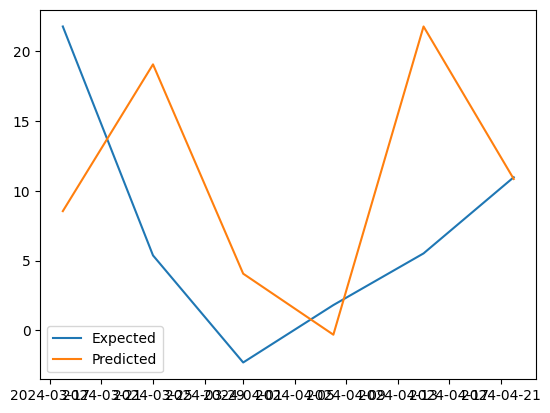

In [49]:
# plot expected vs preducted
plt.plot(df_test['wPreis'], label='Expected')
plt.plot(predictions_series, label='Predicted')
plt.legend()
plt.show()

This was walk-forward validation

## All other clusters and categories 

In [50]:
def static_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    df_train, df_test = data[0:-nobs], data[-nobs:]


    # Define the forecaster
    forecaster = ForecasterAutoreg(
    # Add the sklearn regressor and lags
    regressor = DecisionTreeRegressor(random_state = 123),
    lags = 4
    )

    y_train = df_train['wPreis']
    forecaster.fit(y=y_train)
    predicted_test = forecaster.predict(steps = len(df_test))
    predicted_test.index = df_test.index

    print(f'Decision Tree Static Forecast Accuracy of: wPreis in {cluster} for {category}')
    stat_accuracy_prod = forecast_accuracy(predicted_test, df_test['wPreis'])
    for k, v in stat_accuracy_prod.items():
        print(adjust(k), ': ', round(v,4))






In [51]:
def rolling_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    dt_data = series_to_supervised(X, n_in=4)


    train, test = train_test_split(dt_data, 6)
    train = asarray(train)
    trainX, trainy = train[:, :-1], train[:, -1]


    model_dt_rolling = DecisionTreeRegressor(random_state=42, max_depth = 3)
    model_dt_rolling.fit(trainX, trainy)

    predictions = list()
    direction_accuracies = list()   

    for i in range(len(test)):
        # split test row into input and output columns
        testX, testy = test[i, :-1], test[i, -1]
        # ONLY MAKE ONE-STEP PREDICTIONS BASED ON MODEL TRAINED ONCE 
        # print([testX])
        yhat = model_dt_rolling.predict([testX])
        # store forecast in list of predictions
        predictions.append(yhat[0])
        if i > 0:  # Direction accuracy is not applicable for the first prediction
                forecast_diff = yhat - predictions[-2]
                actual_diff = testy - test[i - 1, -1]
                direction_accuracy = int(np.sign(forecast_diff) == np.sign(actual_diff))
                direction_accuracies.append(direction_accuracy)
        # summarize progress
        # print('>expected=%.1f, predicted=%.1f' % (testy, yhat))


    mae = mean_absolute_error(test[:, -1], predictions)
    me = np.mean(predictions - test[:, -1])  # Mean Error
    rmse = mean_squared_error(test[:, -1], predictions, squared=False)
    overall_direction_accuracy = np.mean(direction_accuracies)

    print(f'Decision Tree Rolling forecast Accuracy of: wPreis in {cluster} for {category}')
    print('MAE: %.3f' % mae)
    print('ME: %.3f' % me)
    print('RMSE: %.3f' % rmse)
    print('Direction Accuracy: %.3f' % overall_direction_accuracy)

In [52]:
def wf_forecast(data):
    category = data['full'].unique()
    cluster = data['Plz'].unique()
    splitratio = 0.05
    nobs = round(len(data)*splitratio)

    X = data["wPreis"].values.reshape(-1, 1)

    dt_data = series_to_supervised(X, n_in=4)

    print(f'Decision Tree Walk-forward forecast Accuracy of: wPreis in {cluster} for {category}')
    wf_accuracy_prod = dt_walk_forward_validation(dt_data, nobs)
    mae = wf_accuracy_prod['mae']
    me = wf_accuracy_prod['me']
    rmse = wf_accuracy_prod['rmse']
    expected = wf_accuracy_prod['expected']
    predictions = wf_accuracy_prod['predictions']
    direction_accuracy = wf_accuracy_prod['direction_accuracy']
    print('MAE: %.3f' % mae)
    print('ME: %.3f' % me)
    print('RMSE: %.3f' % rmse)
    print('Direction Accuracy: %.3f' % direction_accuracy)


In [53]:
clusters = df['Plz'].unique() 
datasets = []
for cluster in clusters:
    ds = df[(df['Plz'] == cluster)]
    categories = ds['full'].unique()
    for category in categories:
        datasets.append(ds[ds['full'] == category])

In [54]:
import warnings

# Filter out the specific warning
warnings.filterwarnings('ignore', message="A date index has been provided, but it has no associated frequency information")

In [55]:
# datasets = [TS1_A2, TS1_A1A2, TS1_A2A3]
# Loop through each category
for dataset in datasets:
    static_forecast(dataset)
    rolling_forecast(dataset)
    wf_forecast(dataset)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versi

Decision Tree Static Forecast Accuracy of: wPreis in ["['25', '24']"] for ['A2 -  geschreddert']
mae    :  14.5852
me     :  12.801
rmse   :  16.8216
direction_accuracy :  0.125
Decision Tree Rolling forecast Accuracy of: wPreis in ["['25', '24']"] for ['A2 -  geschreddert']
MAE: 10.349
ME: 7.547
RMSE: 11.770
Direction Accuracy: 0.200
Decision Tree Walk-forward forecast Accuracy of: wPreis in ["['25', '24']"] for ['A2 -  geschreddert']
MAE: 8.953
ME: 6.383
RMSE: 11.378
Direction Accuracy: 0.500
Decision Tree Static Forecast Accuracy of: wPreis in ["['25', '24']"] for ['A1 & A2 -  geschreddert']
mae    :  10.6173
me     :  6.9747
rmse   :  11.5339
direction_accuracy :  0.25
Decision Tree Rolling forecast Accuracy of: wPreis in ["['25', '24']"] for ['A1 & A2 -  geschreddert']
MAE: 8.280
ME: 2.798
RMSE: 10.178
Direction Accuracy: 0.400
Decision Tree Walk-forward forecast Accuracy of: wPreis in ["['25', '24']"] for ['A1 & A2 -  geschreddert']
MAE: 6.921
ME: 1.779
RMSE: 8.684
Direction Accu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versi

MAE: 3.513
ME: -1.704
RMSE: 4.387
Direction Accuracy: 0.625
Decision Tree Static Forecast Accuracy of: wPreis in ["['70', '71', '73', '74', '75', '76']"] for ['A2 & A3 -  geschreddert']
mae    :  6.6567
me     :  -5.5195
rmse   :  9.1155
direction_accuracy :  0.7143
Decision Tree Rolling forecast Accuracy of: wPreis in ["['70', '71', '73', '74', '75', '76']"] for ['A2 & A3 -  geschreddert']
MAE: 4.325
ME: 2.895
RMSE: 4.507
Direction Accuracy: 0.000
Decision Tree Walk-forward forecast Accuracy of: wPreis in ["['70', '71', '73', '74', '75', '76']"] for ['A2 & A3 -  geschreddert']
MAE: 7.734
ME: 3.254
RMSE: 8.839
Direction Accuracy: 0.857
Decision Tree Static Forecast Accuracy of: wPreis in ["['50', '51', '52', '53']"] for ['A2 & A3 -  geschreddert']
mae    :  3.3426
me     :  -1.991
rmse   :  4.2557
direction_accuracy :  0.25
Decision Tree Rolling forecast Accuracy of: wPreis in ["['50', '51', '52', '53']"] for ['A2 & A3 -  geschreddert']
MAE: 2.883
ME: 2.540
RMSE: 3.339
Direction Accura

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versi

Decision Tree Static Forecast Accuracy of: wPreis in ["['10', '11', '12', '13', '14', '15', '16']"] for ['A2 -  geschreddert']
mae    :  10.1319
me     :  6.7405
rmse   :  11.8655
direction_accuracy :  0.4286
Decision Tree Rolling forecast Accuracy of: wPreis in ["['10', '11', '12', '13', '14', '15', '16']"] for ['A2 -  geschreddert']
MAE: 13.178
ME: 11.772
RMSE: 15.172
Direction Accuracy: 0.000
Decision Tree Walk-forward forecast Accuracy of: wPreis in ["['10', '11', '12', '13', '14', '15', '16']"] for ['A2 -  geschreddert']
MAE: 7.647
ME: 4.027
RMSE: 11.585
Direction Accuracy: 0.571
Decision Tree Static Forecast Accuracy of: wPreis in ["['29', '30', '31', '38', '39']"] for ['A2 & A3 -  geschreddert']
mae    :  5.5431
me     :  -1.1921
rmse   :  6.8831
direction_accuracy :  0.25
Decision Tree Rolling forecast Accuracy of: wPreis in ["['29', '30', '31', '38', '39']"] for ['A2 & A3 -  geschreddert']
MAE: 5.422
ME: 4.858
RMSE: 7.085
Direction Accuracy: 0.000
Decision Tree Walk-forward fo

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:867: UserWarning: `last_window` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/skforecast/utils/utils.py:805: UserWarning: `y` has DatetimeIndex index but no frequency. Index is overwritten with a RangeIndex of step 1.
  warnings.warn(
/Library/Frameworks/Python.framework/Versi